In [1]:
import dataclasses
import theano.tensor as tt
import theano
import sympy as sym
from scipy import linalg, stats, optimize
import arviz
import seaborn as sns
import pymc3 as pm
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sunode.wrappers.as_theano import solve_ivp

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# See data_management.R

day_start = pd.to_datetime("2019-12-30")
day_data = pd.to_datetime("2019-12-08")

if day_data <= day_start:
    day_data = day_start + datetime.timedelta(days=2)

day_tmax = pd.to_datetime("2020-02-11")
day_tswitch = pd.to_datetime("2020-01-23")
time_lag = 100

t0 = 0
tmax = (day_tmax - day_start).days
n_time = tmax + time_lag
tvals = np.arange(n_time)
t_data = (day_data - day_start).days
#D = tmax-t_data+1
n_observed = tmax - t_data  # TODO +1
tswitch = (day_tswitch - day_start).days

# Age distribution in China for 9 age classes ---------
# (https://www.worldometers.info/demographics/china-demographics/) 

age_dist = np.array([
  83932437 + 86735183,
  84262751 + 82341859,
  87158167+ 97989003,
  128738970 + 100091455, 
  96274146 + 119837617,
  123445382 + 98740491,
  77514139 + 74149766,
  44949689 + 26544616,
  16181417 + 7581777 + 2305024 + 475193 + 74692
])
age_dist = age_dist / age_dist.sum()

# Population in Hubei ---------
# (National Bureau of Statistics of China) 

pop_t = 59020000

# Case incidence in Hubei up to 2020-02-11 ---------
# (Chinese CDC Weekly, The epidemiological characteristics of an outbreak...)

confirmed_cases = pd.read_csv("../data/confirmed_cases.csv")
confirmed_cases['date'] = pd.to_datetime(
    dict(
        year=confirmed_cases.year,
        month=confirmed_cases.month,
        day=confirmed_cases.day
    )
)
confirmed_cases = confirmed_cases[confirmed_cases.date >= day_data]
incidence_cases = confirmed_cases.confirmed_cases_hubei

incidence_deaths = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
    0, 0, 1, 1, 2, 3, 7, 7, 14, 13, 21, 23, 23,
    33, 38, 40, 40, 50, 56, 58, 64, 64, 76, 78,
    85, 95, 85
])

cases_tmax = np.array([416, 549, 3619, 7600, 8571, 10008, 8583, 3918, 1408])
prop_cases_tmax = cases_tmax / cases_tmax.sum()

mort_tmax = np.array([0,1,7,18,38,130,309,312,208])
prop_mort_tmax = mort_tmax / mort_tmax.sum()

In [3]:
linton_mean = 20.2
linton_sd = 11.6

def get_par_lnorm(m, s):
    mu = np.log(m) - np.log((s / m) ** 2 + 1) / 2
    sigma = np.sqrt(np.log((s / m) ** 2 + 1))
    return {
        'mu': mu,
        'sigma': sigma
    }

linton_pars = get_par_lnorm(linton_mean,linton_sd)

dist = stats.lognorm(s=linton_pars['sigma'], scale=np.exp(linton_pars['mu']))
gamma = dist.cdf(np.arange(60) + 1.5) - dist.cdf(np.arange(60) - 0.5)
gamma = gamma / gamma.sum()

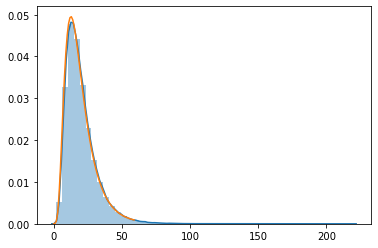

In [4]:
sns.distplot(dist.rvs(100000))
plt.plot(gamma)

In [5]:
linton_mean = 20.2
linton_sd = 11.6

def get_par_lnorm(m, s):
    mu = np.log(m) - np.log((s / m) ** 2 + 1) / 2
    sigma = np.sqrt(np.log((s / m) ** 2 + 1))
    return {
        'mu': mu,
        'sigma': sigma
    }

linton_pars = get_par_lnorm(linton_mean,linton_sd)

dist = stats.lognorm(s=linton_pars['sigma'], scale=np.exp(linton_pars['mu']))
p_gamma = dist.cdf(np.arange(60) + 1.5) - dist.cdf(np.arange(60) - 0.5)
p_gamma = p_gamma / p_gamma.sum()

t0 = 0
tmax2 = tmax
agedistr_cases = cases_tmax
agedistr_deaths = mort_tmax

In [154]:
def switch_eta(t, t1, eta, nu, xi):
    return eta + (1 - eta) / (1 + np.exp(xi * (t - t1 - nu)))

def switch_zero(t, t1):
    return 1 / (1 + np.exp(5 * (t - t1)))

In [89]:
t = tvals

In [93]:
dets['eta']

array(0.49911103)

In [94]:
dets['nu']

array(4.99478235)

In [97]:
dets['xi_raw'] + 0.5

1.0000030537939666

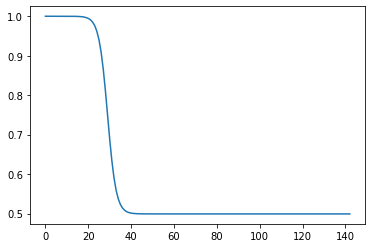

In [113]:
plt.plot(tvals, switch_eta(tvals, tswitch, dets['eta'], dets['nu'],  .5))

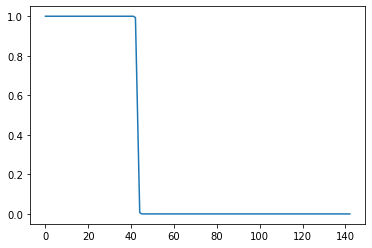

In [156]:
plt.plot(tvals, switch_zero(tvals, tmax2))

In [6]:
def switch_zero_sym(t, t1):
    return 1 / (1 + sym.exp(5 * (t - t1)))


def switch_eta_sym(t, t1, eta, nu, xi):
    return eta + (1 - eta) / (1 + sym.exp(xi * (t - t1 - nu)))


def seir_rhs(t, y, p):
    # Total number of infectious people
    exp = np.vectorize(sym.exp)
    y_type = type(y)
    y = {name: exp(val) for name, val in dataclasses.asdict(y).items()}
    y = y_type(**y)
    
    nI = sum(y.I)
    ntot = sum(y.S + y.E + y.I + y.A)
    p_tmax = switch_zero_sym(t, p.tmax2)
    p_tswitch = switch_eta_sym(t, p.tswitch, p.eta, p.nu, p.xi)
    
    out = {
        'S': -p.beta * p_tswitch * y.S * nI / ntot,
        'E': (
            p.beta * p_tswitch * y.S * nI / ntot
            - 1 / p.inv_tau * p_tmax * y.E
        ),
        'I': (
            p.psi / p.inv_tau * p_tmax * y.E
            - 1 / p.inv_mu * y.I
        ),
        'A': (
            (1 - p.psi) / p.inv_tau * p_tmax * y.E
            - 1 / p.inv_mu * y.A
        ),
        'R': (
            1 / p.inv_mu * (y.I + y.A)
        ),
        'C': p.psi / p.inv_tau * p_tmax * y.E
    }
    return {name: val / getattr(y, name) for name, val in out.items()}


In [7]:
# TODO These numbers are just placeholders for now
n_ages = len(agedistr_cases)

default_priors = [
    ('beta', pm.Exponential, {'lam': 1}),
    ('eta', pm.Beta, {'alpha': 1, 'beta': 1}),
    ('epsilon', pm.Beta, {'alpha': 1, 'beta': 1, 'shape': n_ages}),
    ('rho', pm.Beta, {'alpha': 1, 'beta': 1, 'shape': n_ages - 1}),
    ('pi', pm.Beta, {'alpha': 1, 'beta': 999}),
    ('phi', pm.Exponential, {'lam': 0.01, 'shape': 2}),
    ('xi_raw', pm.Beta, {'alpha': 1, 'beta': 1}),
    ('nu', pm.Exponential, {'lam': 0.2}),
]

p_incubation = 5.6
p_infectious = 2.9

default_ode_params = {
    'inv_tau': p_incubation,
    'inv_mu': p_infectious,
    'psi': 0.49,
    'tmax2': np.array(tmax, dtype='d'),
    'tswitch': np.array(tswitch, dtype='d'),
}

#age_dist = np.ones(n_ages)
#t0 = 0
#tvals = np.linspace(0, 1000)
n_time = len(tvals)
#pop_t = 1
observed_slice = slice(-len(incidence_cases), None)
#p_gamma = np.ones(len(tvals) - observed_slice.start)

In [37]:
prior_overrides = {
    'pi': {'beta': 9999}
}

ode_params_overrides = {}

In [38]:
class ModelConfig:
    pass

In [39]:
# TODO Wrap in make_model function
with pm.Model() as model:
    priors = {}
    for name, dist, params in default_priors:
        params = params.copy()
        params.update(prior_overrides.get(name, {}))
        rv = dist(name, **params)
        priors[name] = rv

    xi = priors['xi_raw'] + 0.5
    pm.Deterministic('xi', xi)

    rho_K = tt.concatenate([priors['rho'], [1]])

    y0 = {
        'S': (age_dist * (1 - priors['pi']), (n_ages,)),
        'E': (age_dist * priors['pi'], (n_ages,)),
        'I': np.zeros(n_ages),
        'A': np.zeros(n_ages),
        'R': np.zeros(n_ages),
        'C': np.zeros(n_ages),
    }
    
    y0 = {
        'S': (tt.log(age_dist * (1 - priors['pi'])), (n_ages,)),
        'E': (tt.log(age_dist * priors['pi']), (n_ages,)),
        'I': -30 * np.ones(n_ages),
        'A': -30 * np.ones(n_ages),
        'R': -30 * np.ones(n_ages),
        'C': -30 * np.ones(n_ages),
    }


    params = {
        name: (priors[name], ())
        for name in ['beta', 'eta', 'nu']
    }
    params['xi'] = (xi, ())

    ode_params = default_ode_params.copy()
    ode_params.update(ode_params_overrides)
    params.update({
        name: (val, ())
        for name, val in ode_params.items()
    })

    y, flat_solution, problem, solver, *_ = solve_ivp(
        t0=t0,
        y0=y0,
        params=params,
        tvals=tvals,
        rhs=seir_rhs,
        #solver_kwargs={
        #    'constraints': np.ones(6 * n_ages),
        #},
    )
    
    for name in y:
        pm.Deterministic(f'log_y_{name}', y[name])

    for name in y:
        y[name] = pop_t * tt.exp(y[name])
    
    #for name in y:
    #    y[name] = pop_t * y[name]
    
    diff_C = tt.concatenate([
        y['C'][:1, :],
        y['C'][1:, :] - y['C'][:-1, :]],
    )
    
    pm.Deterministic('diff_C', diff_C)
    diff_C = tt.log1p(tt.exp(diff_C))
    pm.Deterministic('abs_diff_C', diff_C)
    
    # TODO something like this
    #diff_M = tt.signal.conv.conv2d(diff_C * prior['epsilon'][None, :], [p_gamma])
    # or this
    diff_M = tt.dot(
        linalg.toeplitz(
            np.r_[p_gamma[::-1], [0] * (n_time - len(p_gamma))],
            np.zeros(n_time),
        ),
        diff_C * priors['epsilon'][None, :]
    )
    
    y['M'] = diff_M
    
    for name in y:
        pm.Deterministic(f'y_{name}', y[name])
    
    output_incidence_cases = tt.dot(diff_C[observed_slice], rho_K)
    output_incidence_deaths = tt.sum(diff_M[observed_slice, :], axis=1)
    
    cases_end = y['C'][-1] * rho_K  # + 1e-9
    output_agedistr_cases = cases_end / cases_end.sum()
    output_agedistr_deaths = y['M'][-1] / y['M'][-1].sum()
    
    pm.Deterministic('output_agedistr_cases', output_agedistr_cases)
    pm.Deterministic('output_agedistr_deaths', output_agedistr_deaths)
    pm.Deterministic('output_incidence_cases', output_incidence_cases)
    pm.Deterministic('output_incidence_deaths', output_incidence_deaths)
    
    pm.Multinomial(
        'cases_by_age',
        n=agedistr_cases.sum(),
        p=output_agedistr_cases,
        observed=agedistr_cases,
    )
    pm.Multinomial(
        'deaths_by_age',
        n=agedistr_deaths.sum(),
        p=output_agedistr_deaths,
        observed=agedistr_deaths,
    )
    
    #output_incidence_cases = tt.nnet.softplus(output_incidence_cases)
    pm.NegativeBinomial(
        'cases',
        mu=output_incidence_cases,
        alpha=output_incidence_cases / priors['phi'][0],
        observed=incidence_cases.values
    )
    
    #output_incidence_deaths = tt.nnet.softplus(output_incidence_deaths)
    pm.NegativeBinomial(
        'deaths',
        mu=output_incidence_deaths,
        alpha=output_incidence_deaths / priors['phi'][1],
        observed=incidence_deaths,
    )


    output = ModelConfig()
    output.model = model
    output.problem = problem
    output.solver = solver
    #return output  # TODO Save stuff in output

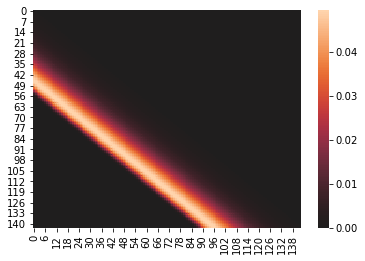

In [40]:
sns.heatmap(
    linalg.toeplitz(
        np.r_[p_gamma[::-1], [0] * (n_time - len(p_gamma))],
        np.zeros(n_time),
    ),
    center=0
)

In [41]:
func = model.logp_dlogp_function()
func.set_extra_values({})
x0 = np.random.randn(func.size)

In [42]:
with model:
    prior = pm.sample_prior_predictive(samples=1)

In [43]:
func(x0)

(array(-36732.30987559),
 array([-3.46810973e-01, -5.58996041e-01, -5.79323288e+01, -5.73726080e+01,
        -5.38932412e+01, -4.07487612e+01, -3.91044400e+01,  7.72745177e+01,
         1.13795781e+02,  1.24009668e+02,  2.13806348e+01, -2.45905566e+03,
        -2.18515272e+03, -1.36963877e+03, -5.51360893e+02,  9.73620762e+02,
         3.36799493e+03,  4.11528552e+03,  1.20524452e+03, -2.23454813e+03,
         1.40552048e+04,  1.41724150e+02, -1.01273557e-01,  7.28783132e-01]))

In [44]:
def loss(x):
    logp, grad = func(x)
    return -logp, -grad

In [45]:
opt = optimize.minimize(loss, jac=True, x0=x0)

In [114]:
point = func.array_to_dict(opt.x)

In [75]:
point['pi_logodds__'] = np.array(-50)

In [115]:
point['beta_log__']

array(-0.01365526)

In [147]:
point['beta_log__'] = -10

In [148]:
dets_func = theano.function(model.free_RVs, model.deterministics)
dets = dets_func(**point)
dets = {var.name: val for var, val in zip(model.deterministics, dets)}

In [149]:
dets['output_incidence_deaths']

array([2.18576979, 2.18576533, 2.185765  , 2.18576499, 2.18576499,
       2.18576499, 2.18576499, 2.18576499, 2.18576499, 2.18576499,
       2.18576499, 2.18576499, 2.18576499, 2.18576499, 2.18576499,
       2.18576499, 2.18576499, 2.18576499, 2.18576499, 2.18576499,
       2.18576499, 2.18576499, 2.18576499, 2.18576499, 2.18576499,
       2.18576499, 2.18576499, 2.18576499, 2.18576499, 2.18576499,
       2.18576499, 2.18576499, 2.18576499, 2.18576499, 2.18576499,
       2.18576499, 2.18576499, 2.18576499, 2.18576499, 2.18576499,
       2.18576499, 2.18576499])

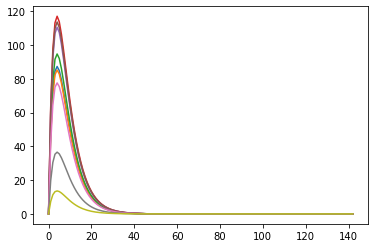

In [151]:
plt.plot(dets['y_I'])

In [56]:
tmax

43

In [57]:
ode_params

{'inv_tau': 5.6,
 'inv_mu': 2.9,
 'psi': 0.49,
 'tmax2': array(43.),
 'tswitch': array(24.)}

In [58]:
0.49 / 5.6

0.08750000000000001

In [64]:
(dets['pi']) * pop_t

5886.930720081408

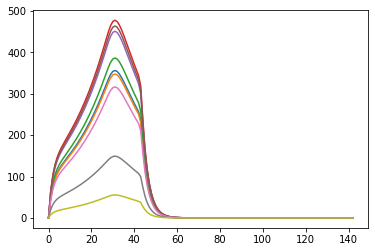

In [60]:
plt.plot(dets['y_I'])

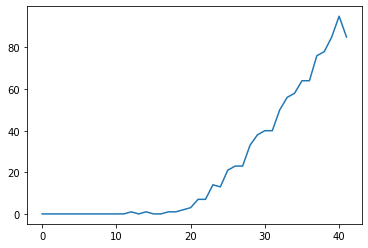

In [27]:
plt.plot(incidence_deaths)

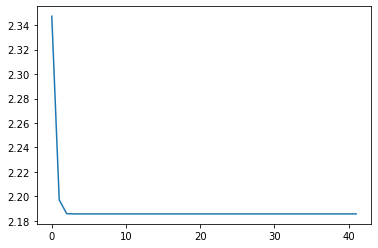

In [28]:
plt.plot(dets['output_incidence_deaths'])

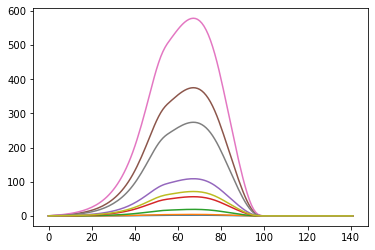

In [30]:
plt.plot(dets['y_M'][1:])

In [65]:
%timeit func(x0)

50.8 ms ± 781 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
import sunode

In [113]:
lib = sunode._cvodes.lib
lib.CVodeSStolerances(solver._ode, 1e-10, 1e-10)
lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-8, 1e-8)
lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-8, 1e-8)
#lib.CVodeSetMaxNumSteps(solver._ode, 5000)
#lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 5000)
#lib.CVodeSetMaxStep(solver._ode, 120)
#lib.CVodeSetMaxStepB(solver._ode, solver._odeB, 300)


0

In [114]:
beta = tt.dscalar('__beta')
beta.tag.test_value = 1.
priors = tt.sum([var.logpt for var in model.free_RVs])
observed = tt.sum([var.logpt for var in model.observed_RVs])

func = pm.model.ValueGradFunction(priors + beta * observed, model.free_RVs, [beta])

func.set_extra_values({beta.name: 1.})


class TemperingAdapt(pm.step_methods.hmc.quadpotential.QuadPotentialFull):
    """Adapt a dense mass matrix using the sample covariances."""
    def __init__(
        self,
        n,
        initial_mean,
        initial_cov,
        func,
        n_tune,
        n_steps,
        n_tempering,
        update_window=50,
        initial_weight=100,
        dtype=None,
    ):
        #self._betas = list(np.linspace(0, 1, n_steps)[1:])
        #self._betas = list(np.logspace(-3, 0, n_steps)[1:])
        self._n_steps = n_steps
        #self._betas = list(np.repeat(scipy.special.expit(np.linspace(-8, 4, n_steps // 3)), 2))
        #self._betas = list(np.repeat(scipy.special.expit(np.linspace(-7, 5, n_steps // 3)), 2))
        #self._betas.extend([1] * n_steps)
        
        self._window_length = n_tune // n_steps
        self._window = 0
        self._func = func
        self._n_tempering = n_tempering
        
        self._func.set_extra_values({'__beta': self.get_beta(0)})

        if initial_cov is not None and initial_cov.ndim != 2:
            raise ValueError("Initial covariance must be two-dimensional.")
        if initial_mean.ndim != 1:
            raise ValueError("Initial mean must be one-dimensional.")
        if initial_cov is not None and initial_cov.shape != (n, n):
            raise ValueError(
                "Wrong shape for initial_cov: expected %s got %s"
                % (n, initial_cov.shape)
            )
        if len(initial_mean) != n:
            raise ValueError(
                "Wrong shape for initial_mean: expected %s got %s"
                % (n, len(initial_mean))
            )

        if dtype is None:
            dtype = theano.config.floatX

        if initial_cov is None:
            initial_cov = np.eye(n, dtype=dtype)
            initial_weight = 1

        self.dtype = dtype
        self._n = n
        self._cov = np.array(initial_cov, dtype=self.dtype, copy=True)
        self._chol = scipy.linalg.cholesky(self._cov, lower=True)
        self._chol_error = None
        self._foreground_cov = pm.step_methods.hmc.quadpotential._WeightedCovariance(
            self._n, initial_mean, initial_cov, initial_weight, self.dtype
        )
        self._background_cov = pm.step_methods.hmc.quadpotential._WeightedCovariance(self._n, dtype=self.dtype)
        self._n_samples = 0

        self._update_window = int(update_window)
        self._previous_update = 0
        
    def get_beta(self, i):
        a = -7
        b = 4
        return scipy.special.expit((b - a) * i / self._n_tempering + a)
        #return i / self._n_tempering
    
    def _update_from_weightvar(self, weightvar):
        weightvar.current_covariance(out=self._cov)
        if self._n_samples < self._n_tempering / 3:
            self._cov = np.diag(np.diag(self._cov))

        try:
            self._chol = scipy.linalg.cholesky(self._cov, lower=True)
            #self._chol = np.sqrt(self._cov)
        except (scipy.linalg.LinAlgError, ValueError) as error:
            self._chol_error = error

    def update(self, sample, grad, tune, stepadapt):
        if not tune:
            return

        # Steps since previous update
        delta = self._n_samples - self._previous_update

        self._foreground_cov.add_sample(sample, weight=1)
        self._background_cov.add_sample(sample, weight=1)

        if self._n_samples < self._n_tempering:
            self._func.set_extra_values({'__beta': self.get_beta(self._n_samples)})
            #self._func.set_extra_values({'__beta': 1.})
        elif self._n_samples == self._n_tempering:
            stepadapt.reset(0.6)
            self._func.set_extra_values({'__beta': 1.})
            #lib.CVodeSStolerances(solver._ode, 1e-14, 1e-14)
            #lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-12, 1e-12)
            #lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-12, 1e-12)

        # Reset the background covariance if we are at the end of the adaptation
        # window.
        if delta >= self._window_length:
            self._foreground_cov = self._background_cov
            self._background_cov = pm.step_methods.hmc.quadpotential._WeightedCovariance(
                self._n, dtype=self.dtype
            )

            self._previous_update = self._n_samples
            self._window += 1
            self._update_from_weightvar(self._foreground_cov)
            if self._n_samples >= 2 * self._n_steps // 3:
                self._window_length *= 1.5
        #else:
        # Update the covariance matrix and recompute the Cholesky factorization
        # every "update_window" steps
        #    if self._window >= self._n_steps // 2 and (delta + 1) % self._update_window == 0:
        #        self._update_from_weightvar(self._foreground_cov)
                
        self._n_samples += 1

    def raise_ok(self, vmap):
        if self._chol_error is not None:
            raise ValueError("{0}".format(self._chol_error))

In [115]:
with model:
    prior = pm.sample_prior_predictive(100)

stds = {name: vals.std(0) for name, vals in prior.items() if vals.ndim > 0}
means = {name: vals.mean(0) for name, vals in prior.items() if vals.ndim > 0}
points = [{name: vals[i] for name, vals in prior.items() if vals.ndim > 0} for i in range(6)]

import scipy.special
import scipy.linalg

In [118]:
import theano

In [119]:
with model:
    pot = TemperingAdapt(
        func.size,
        func.dict_to_array(means),
        np.diag(func.dict_to_array(stds) ** 2),
        func,
        2_000,
        20,
        1500,
    )
    step = pm.NUTS(func=func, potential=pot, k=0.6, max_treedepth=10, target_accept=0.6)
    
    trace = pm.sample(
        tune=2000, draws=1000, step=step,
        discard_tuned_samples=False, chains=6, cores=6,
        start=points, compute_convergence_checks=False
    )

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [nu, xi_raw, phi, pi, rho, epsilon, eta, beta]


There were 864 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 494 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7904571237894046, but should be close to 0.6. Try to increase the number of tuning steps.


In [132]:
tr.posterior

<xarray.Dataset>
Dimensions:                        (chain: 2, draw: 3000, epsilon_dim_0: 9, output_agedistr_cases_dim_0: 9, output_agedistr_deats_dim_0: 9, output_incidence_cases_dim_0: 42, output_incidence_deaths_dim_0: 42, phi_dim_0: 2, rho_dim_0: 8, y_A_dim_0: 143, y_A_dim_1: 9, y_C_dim_0: 143, y_C_dim_1: 9, y_E_dim_0: 143, y_E_dim_1: 9, y_I_dim_0: 143, y_I_dim_1: 9, y_M_dim_0: 143, y_M_dim_1: 9, y_R_dim_0: 143, y_R_dim_1: 9, y_S_dim_0: 143, y_S_dim_1: 9)
Coordinates:
  * chain                          (chain) int64 0 1
  * draw                           (draw) int64 0 1 2 3 ... 2996 2997 2998 2999
  * epsilon_dim_0                  (epsilon_dim_0) int64 0 1 2 3 4 5 6 7 8
  * rho_dim_0                      (rho_dim_0) int64 0 1 2 3 4 5 6 7
  * phi_dim_0                      (phi_dim_0) int64 0 1
  * y_S_dim_0                      (y_S_dim_0) int64 0 1 2 3 ... 139 140 141 142
  * y_S_dim_1                      (y_S_dim_1) int64 0 1 2 3 4 5 6 7 8
  * y_E_dim_0                      (y_E_dim_0) int64 0 1 2 3 ... 139 140 141 142
  * y_E_dim_1                      (y_E_dim_1) int64 0 1 2 3 4 5 6 7 8
  * y_I_dim_0                      (y_I_dim_0) int64 0 1 2 3 ... 139 140 141 142
  * y_I_dim_1                      (y_I_dim_1) int64 0 1 2 3 4 5 6 7 8
  * y_A_dim_0                      (y_A_dim_0) int64 0 1 2 3 ... 139 140 141 142
  * y_A_dim_1                      (y_A_dim_1) int64 0 1 2 3 4 5 6 7 8
  * y_R_dim_0                      (y_R_dim_0) int64 0 1 2 3 ... 139 140 141 142
  * y_R_dim_1                      (y_R_dim_1) int64 0 1 2 3 4 5 6 7 8
  * y_C_dim_0                      (y_C_dim_0) int64 0 1 2 3 ... 139 140 141 142
  * y_C_dim_1                      (y_C_dim_1) int64 0 1 2 3 4 5 6 7 8
  * y_M_dim_0                      (y_M_dim_0) int64 0 1 2 3 ... 139 140 141 142
  * y_M_dim_1                      (y_M_dim_1) int64 0 1 2 3 4 5 6 7 8
  * output_agedistr_cases_dim_0    (output_agedistr_cases_dim_0) int64 0 1 ... 8
  * output_agedistr_deats_dim_0    (output_agedistr_deats_dim_0) int64 0 1 ... 8
  * output_incidence_cases_dim_0   (output_incidence_cases_dim_0) int64 0 ... 41
  * output_incidence_deaths_dim_0  (output_incidence_deaths_dim_0) int64 0 ... 41
Data variables:
    beta                           (chain, draw) float64 0.2349 0.2349 ... 1.176
    eta                            (chain, draw) float64 0.7547 ... 0.0006512
    epsilon                        (chain, draw, epsilon_dim_0) float64 0.03851 ... 0.4608
    rho                            (chain, draw, rho_dim_0) float64 0.4825 ... 0.5792
    pi                             (chain, draw) float64 0.003377 ... 0.0004442
    phi                            (chain, draw, phi_dim_0) float64 492.0 ... 28.76
    xi_raw                         (chain, draw) float64 0.9349 ... 0.6725
    nu                             (chain, draw) float64 5.81 5.81 ... 14.65
    y_S                            (chain, draw, y_S_dim_0, y_S_dim_1) float64 6.975e+06 ... 0.4652
    y_E                            (chain, draw, y_E_dim_0, y_E_dim_1) float64 2.363e+04 ... 769.0
    y_I                            (chain, draw, y_I_dim_0, y_I_dim_1) float64 5.902e+07 ... 6.374e-13
    y_A                            (chain, draw, y_A_dim_0, y_A_dim_1) float64 5.902e+07 ... 6.621e-13
    y_R                            (chain, draw, y_R_dim_0, y_R_dim_1) float64 5.902e+07 ... 1.782e+08
    y_C                            (chain, draw, y_C_dim_0, y_C_dim_1) float64 5.902e+07 ... 5.955e+07
    y_M                            (chain, draw, y_M_dim_0, y_M_dim_1) float64 2.097e+03 ... 9.758e-10
    output_agedistr_cases          (chain, draw, output_agedistr_cases_dim_0) float64 0.07289 ... 0.1546
    output_agedistr_deats          (chain, draw, output_agedistr_deats_dim_0) float64 0.1111 ... 0.2375
    output_incidence_cases         (chain, draw, output_incidence_cases_dim_0) float64 0.0 ... 0.0
    output_incidence_deaths        (chain, draw, output_incidence_deaths_dim_0) float64 -2.353 ... -4.892e-09


In [140]:
import arviz

tr = arviz.from_pymc3(
    trace=trace,
    log_likelihood=False,
    dims={
        'y_S': ['time', 'age'],
        'y_E': ['time', 'age'],
        'y_I': ['time', 'age'],
        'y_A': ['time', 'age'],
        'y_R': ['time', 'age'],
        'y_C': ['time', 'age'],
        'y_M': ['time', 'age'],
        'output_agedistr_cases': ['age'],
        'output_agedistr_deats': ['age'],
        'output_incidence_cases': ['data_time'],
        'output_incidence_deaths': ['data_time'],
        'epsilon': ['age'],
    },
    coords={
        'age': np.arange(n_ages),
        'time': np.arange(n_time),
        'data_time': np.arange(n_observed + 1),
    }
)

In [141]:
tr.posterior

<xarray.Dataset>
Dimensions:                  (age: 9, chain: 2, data_time: 42, draw: 3000, phi_dim_0: 2, rho_dim_0: 8, time: 143)
Coordinates:
  * chain                    (chain) int64 0 1
  * draw                     (draw) int64 0 1 2 3 4 ... 2995 2996 2997 2998 2999
  * age                      (age) int64 0 1 2 3 4 5 6 7 8
  * rho_dim_0                (rho_dim_0) int64 0 1 2 3 4 5 6 7
  * phi_dim_0                (phi_dim_0) int64 0 1
  * time                     (time) int64 0 1 2 3 4 5 ... 138 139 140 141 142
  * data_time                (data_time) int64 0 1 2 3 4 5 ... 36 37 38 39 40 41
Data variables:
    beta                     (chain, draw) float64 0.2349 0.2349 ... 1.176 1.176
    eta                      (chain, draw) float64 0.7547 0.7547 ... 0.0006512
    epsilon                  (chain, draw, age) float64 0.03851 ... 0.4608
    rho                      (chain, draw, rho_dim_0) float64 0.4825 ... 0.5792
    pi                       (chain, draw) float64 0.003377 ... 0.0004442
    phi                      (chain, draw, phi_dim_0) float64 492.0 ... 28.76
    xi_raw                   (chain, draw) float64 0.9349 0.9349 ... 0.6725
    nu                       (chain, draw) float64 5.81 5.81 ... 14.65 14.65
    y_S                      (chain, draw, time, age) float64 6.975e+06 ... 0.4652
    y_E                      (chain, draw, time, age) float64 2.363e+04 ... 769.0
    y_I                      (chain, draw, time, age) float64 5.902e+07 ... 6.374e-13
    y_A                      (chain, draw, time, age) float64 5.902e+07 ... 6.621e-13
    y_R                      (chain, draw, time, age) float64 5.902e+07 ... 1.782e+08
    y_C                      (chain, draw, time, age) float64 5.902e+07 ... 5.955e+07
    y_M                      (chain, draw, time, age) float64 2.097e+03 ... 9.758e-10
    output_agedistr_cases    (chain, draw, age) float64 0.07289 ... 0.1546
    output_agedistr_deats    (chain, draw, age) float64 0.1111 0.1111 ... 0.2375
    output_incidence_cases   (chain, draw, data_time) float64 0.0 0.0 ... 0.0
    output_incidence_deaths  (chain, draw, data_time) float64 -2.353 ... -4.892e-09
Attributes:
    created_at:                 2020-03-14T11:10:24.484951
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.7

In [ ]:
pm.traceplot(tr, var_names=['beta', 'eta', 'epsilon', 'rho', 'pi', 'phi', 'xi_raw', 'nu'])

In [67]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, xi_raw, phi, pi, rho, epsilon, eta, beta]


RuntimeError: Chain 3 failed.

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
